# Import

In [ ]:
import os
import sys

import numpy as np
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

# Reinitialize TF with the new log level
tf.get_logger().setLevel('ERROR')

sys.path.append('/home/shashank/tfgarden/models')

from official.vision.serving import export_saved_model_lib
import tensorflow_models as tfm
import yaml

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
%matplotlib inline




2025-03-15 09:50:14.172232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742012414.191703 2056760 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742012414.197753 2056760 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 09:50:14.218271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Evaluation

## Function

In [2]:
def evalaution(model_path, test_data_path, custom_chkpt=None):
    # Importing SavedModel
    imported = tf.saved_model.load(model_path)
    model_fn = imported.signatures['serving_default']
    
    if custom_chkpt:
        model_fn.load_weights(custom_chkpt)
    
    test_data = tf.data.TFRecordDataset(test_data_path)
    
    _keys_to_features = {
        'image/encoded_source_id': tf.io.VarLenFeature(tf.string),
        'image/label': tf.io.VarLenFeature(tf.int64),
        'image/encoded': tf.io.FixedLenFeature((), tf.string),     
    }
    
    predictions = []
    labels = []

    for data in test_data:
        dec = tf.io.parse_single_example(data.numpy(), _keys_to_features)
        labels.append(dec["image/label"].values.numpy()[0])
        img = tf.image.resize(tf.io.decode_image(dec["image/encoded"].numpy()), (224, 224))
        pred = np.argmax(model_fn(tf.cast(img[tf.newaxis, ...], dtype=tf.uint8))['logits'], axis=1)[0]
        predictions.append(pred)
        
    disp = ConfusionMatrixDisplay(confusion_matrix(labels, predictions))
    disp.plot()
    plt.show()
    
    print(classification_report(labels, predictions))

## vit_baseline_bs16_focal_lr01

I0000 00:00:1742012425.350818 2056760 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7676 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2025-03-15 09:50:32.713719: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1742012433.173286 2056848 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-15 09:51:42.614764: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


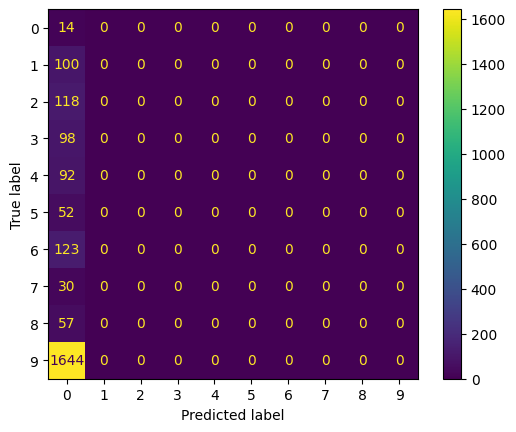

              precision    recall  f1-score   support

           0       0.01      1.00      0.01        14
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       118
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00        92
           5       0.00      0.00      0.00        52
           6       0.00      0.00      0.00       123
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00      1644

    accuracy                           0.01      2328
   macro avg       0.00      0.10      0.00      2328
weighted avg       0.00      0.01      0.00      2328



In [3]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_lr01/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

2025-03-15 09:53:42.954709: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


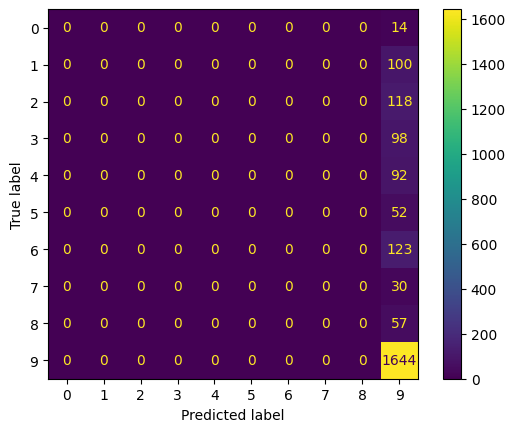

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       118
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00        92
           5       0.00      0.00      0.00        52
           6       0.00      0.00      0.00       123
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00        57
           9       0.71      1.00      0.83      1644

    accuracy                           0.71      2328
   macro avg       0.07      0.10      0.08      2328
weighted avg       0.50      0.71      0.58      2328



In [4]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_lr01"
best_ckpt_idx = "2"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs16_focal_lr0002

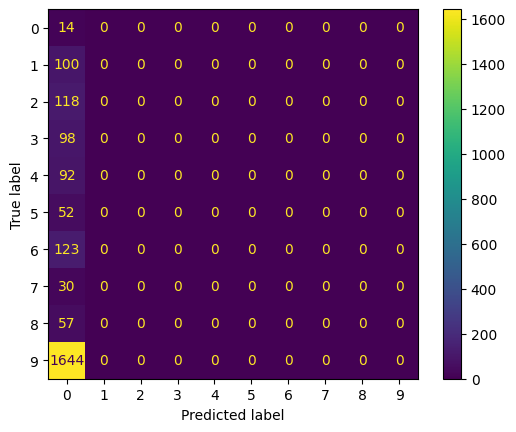

              precision    recall  f1-score   support

           0       0.01      1.00      0.01        14
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       118
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00        92
           5       0.00      0.00      0.00        52
           6       0.00      0.00      0.00       123
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00      1644

    accuracy                           0.01      2328
   macro avg       0.00      0.10      0.00      2328
weighted avg       0.00      0.01      0.00      2328



In [5]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_lr0002/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

2025-03-15 09:56:37.919167: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


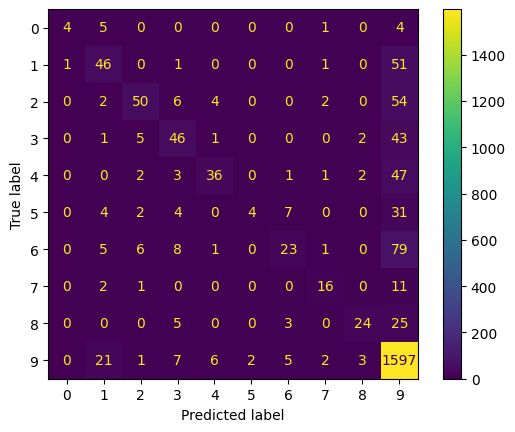

              precision    recall  f1-score   support

           0       0.80      0.29      0.42        14
           1       0.53      0.46      0.49       100
           2       0.75      0.42      0.54       118
           3       0.57      0.47      0.52        98
           4       0.75      0.39      0.51        92
           5       0.67      0.08      0.14        52
           6       0.59      0.19      0.28       123
           7       0.67      0.53      0.59        30
           8       0.77      0.42      0.55        57
           9       0.82      0.97      0.89      1644

    accuracy                           0.79      2328
   macro avg       0.69      0.42      0.49      2328
weighted avg       0.77      0.79      0.76      2328



In [6]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_lr0002"
best_ckpt_idx = "25"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs16_focal_lr5e-05

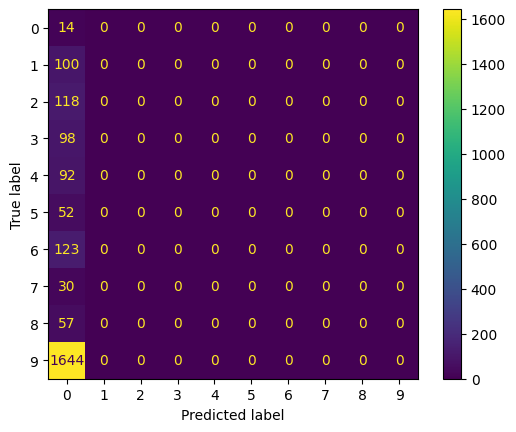

              precision    recall  f1-score   support

           0       0.01      1.00      0.01        14
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       118
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00        92
           5       0.00      0.00      0.00        52
           6       0.00      0.00      0.00       123
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00      1644

    accuracy                           0.01      2328
   macro avg       0.00      0.10      0.00      2328
weighted avg       0.00      0.01      0.00      2328



In [7]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_lr5e-05/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

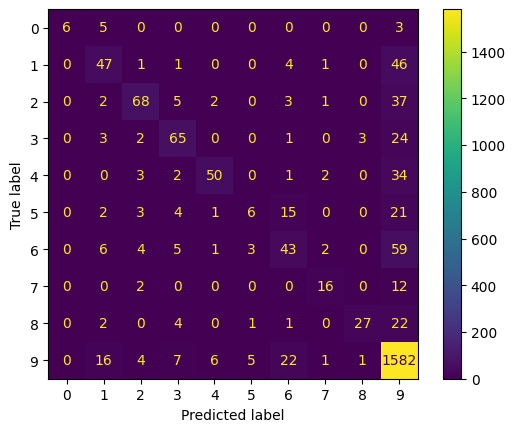

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        14
           1       0.57      0.47      0.51       100
           2       0.78      0.58      0.66       118
           3       0.70      0.66      0.68        98
           4       0.83      0.54      0.66        92
           5       0.40      0.12      0.18        52
           6       0.48      0.35      0.40       123
           7       0.70      0.53      0.60        30
           8       0.87      0.47      0.61        57
           9       0.86      0.96      0.91      1644

    accuracy                           0.82      2328
   macro avg       0.72      0.51      0.58      2328
weighted avg       0.80      0.82      0.80      2328



In [8]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_lr5e-05"
best_ckpt_idx = "24"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs16_focal_cutmixup

I0000 00:00:1741966481.424518 2011819 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7676 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2025-03-14 21:04:48.442617: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1741966488.913695 2014657 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-14 21:05:58.577724: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


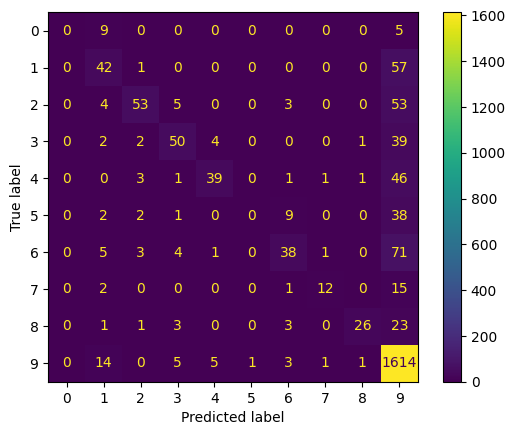

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.52      0.42      0.46       100
           2       0.82      0.45      0.58       118
           3       0.72      0.51      0.60        98
           4       0.80      0.42      0.55        92
           5       0.00      0.00      0.00        52
           6       0.66      0.31      0.42       123
           7       0.80      0.40      0.53        30
           8       0.90      0.46      0.60        57
           9       0.82      0.98      0.90      1644

    accuracy                           0.80      2328
   macro avg       0.60      0.40      0.46      2328
weighted avg       0.77      0.80      0.77      2328



In [3]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_cutmixup/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

2025-03-14 21:08:25.590068: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


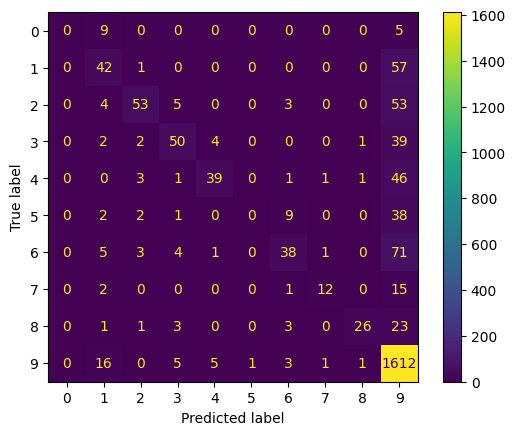

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.51      0.42      0.46       100
           2       0.82      0.45      0.58       118
           3       0.72      0.51      0.60        98
           4       0.80      0.42      0.55        92
           5       0.00      0.00      0.00        52
           6       0.66      0.31      0.42       123
           7       0.80      0.40      0.53        30
           8       0.90      0.46      0.60        57
           9       0.82      0.98      0.89      1644

    accuracy                           0.80      2328
   macro avg       0.60      0.39      0.46      2328
weighted avg       0.77      0.80      0.77      2328



In [4]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_cutmixup"
best_ckpt_idx = "26"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs16_focal_custom

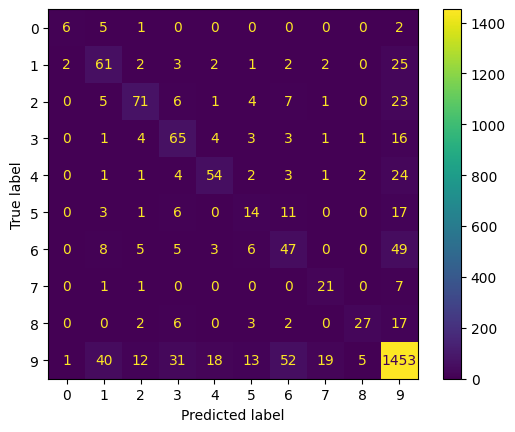

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        14
           1       0.49      0.61      0.54       100
           2       0.71      0.60      0.65       118
           3       0.52      0.66      0.58        98
           4       0.66      0.59      0.62        92
           5       0.30      0.27      0.29        52
           6       0.37      0.38      0.38       123
           7       0.47      0.70      0.56        30
           8       0.77      0.47      0.59        57
           9       0.89      0.88      0.89      1644

    accuracy                           0.78      2328
   macro avg       0.58      0.56      0.56      2328
weighted avg       0.79      0.78      0.78      2328



In [7]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_custom/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

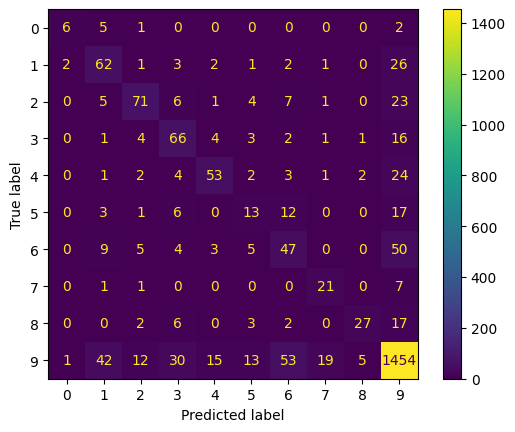

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        14
           1       0.48      0.62      0.54       100
           2       0.71      0.60      0.65       118
           3       0.53      0.67      0.59        98
           4       0.68      0.58      0.62        92
           5       0.30      0.25      0.27        52
           6       0.37      0.38      0.37       123
           7       0.48      0.70      0.57        30
           8       0.77      0.47      0.59        57
           9       0.89      0.88      0.89      1644

    accuracy                           0.78      2328
   macro avg       0.59      0.56      0.56      2328
weighted avg       0.79      0.78      0.78      2328



In [8]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal_custom"
best_ckpt_idx = "20"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs16_focal

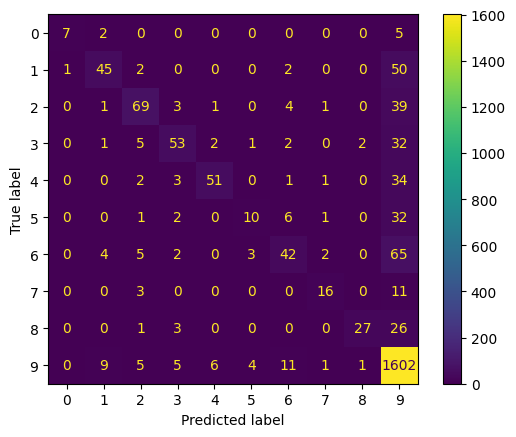

              precision    recall  f1-score   support

           0       0.88      0.50      0.64        14
           1       0.73      0.45      0.56       100
           2       0.74      0.58      0.65       118
           3       0.75      0.54      0.63        98
           4       0.85      0.55      0.67        92
           5       0.56      0.19      0.29        52
           6       0.62      0.34      0.44       123
           7       0.73      0.53      0.62        30
           8       0.90      0.47      0.62        57
           9       0.84      0.97      0.91      1644

    accuracy                           0.83      2328
   macro avg       0.76      0.51      0.60      2328
weighted avg       0.81      0.83      0.81      2328



In [5]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

2025-03-14 16:56:25.734152: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


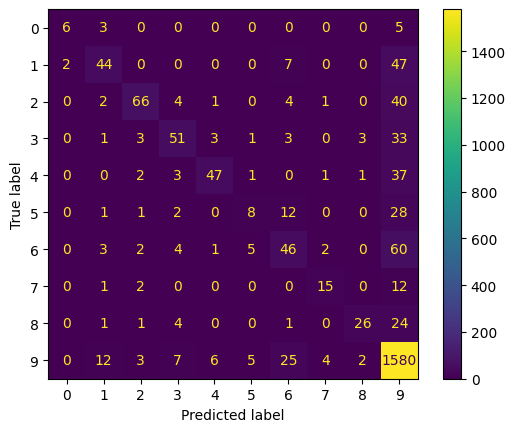

              precision    recall  f1-score   support

           0       0.75      0.43      0.55        14
           1       0.65      0.44      0.52       100
           2       0.82      0.56      0.67       118
           3       0.68      0.52      0.59        98
           4       0.81      0.51      0.63        92
           5       0.40      0.15      0.22        52
           6       0.47      0.37      0.42       123
           7       0.65      0.50      0.57        30
           8       0.81      0.46      0.58        57
           9       0.85      0.96      0.90      1644

    accuracy                           0.81      2328
   macro avg       0.69      0.49      0.56      2328
weighted avg       0.79      0.81      0.79      2328



In [6]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_focal"
best_ckpt_idx = "18"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs16_wcce

I0000 00:00:1741951192.380274 2011500 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7676 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2025-03-14 16:49:59.858943: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1741951200.508098 2011594 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-14 16:51:10.992482: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


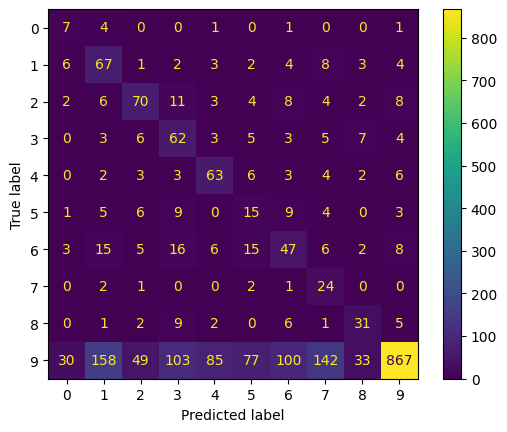

              precision    recall  f1-score   support

           0       0.14      0.50      0.22        14
           1       0.25      0.67      0.37       100
           2       0.49      0.59      0.54       118
           3       0.29      0.63      0.40        98
           4       0.38      0.68      0.49        92
           5       0.12      0.29      0.17        52
           6       0.26      0.38      0.31       123
           7       0.12      0.80      0.21        30
           8       0.39      0.54      0.45        57
           9       0.96      0.53      0.68      1644

    accuracy                           0.54      2328
   macro avg       0.34      0.56      0.38      2328
weighted avg       0.77      0.54      0.59      2328



In [3]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_wcce/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

2025-03-14 16:53:25.495982: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


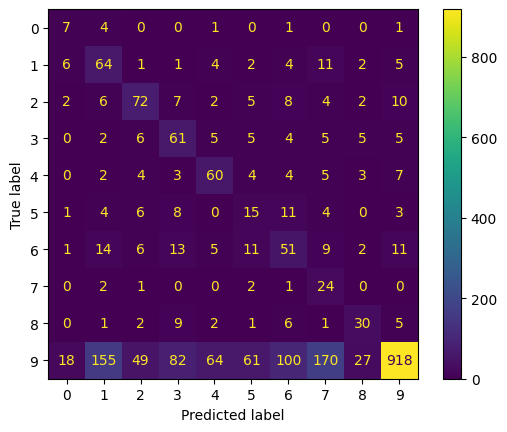

              precision    recall  f1-score   support

           0       0.20      0.50      0.29        14
           1       0.25      0.64      0.36       100
           2       0.49      0.61      0.54       118
           3       0.33      0.62      0.43        98
           4       0.42      0.65      0.51        92
           5       0.14      0.29      0.19        52
           6       0.27      0.41      0.33       123
           7       0.10      0.80      0.18        30
           8       0.42      0.53      0.47        57
           9       0.95      0.56      0.70      1644

    accuracy                           0.56      2328
   macro avg       0.36      0.56      0.40      2328
weighted avg       0.77      0.56      0.62      2328



In [4]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_wcce"
best_ckpt_idx = "19"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs32

I0000 00:00:1741845205.676715  983665 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11220 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2025-03-13 11:23:32.878808: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1741845213.343851  991549 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-13 11:24:42.007203: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


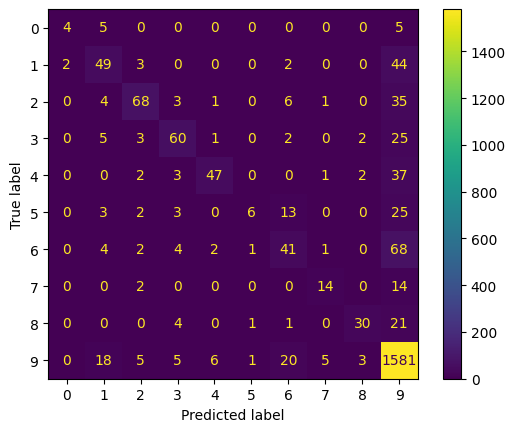

              precision    recall  f1-score   support

           0       0.67      0.29      0.40        14
           1       0.56      0.49      0.52       100
           2       0.78      0.58      0.66       118
           3       0.73      0.61      0.67        98
           4       0.82      0.51      0.63        92
           5       0.67      0.12      0.20        52
           6       0.48      0.33      0.39       123
           7       0.64      0.47      0.54        30
           8       0.81      0.53      0.64        57
           9       0.85      0.96      0.90      1644

    accuracy                           0.82      2328
   macro avg       0.70      0.49      0.56      2328
weighted avg       0.80      0.82      0.80      2328



In [3]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs32/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

2025-03-13 11:27:18.610088: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


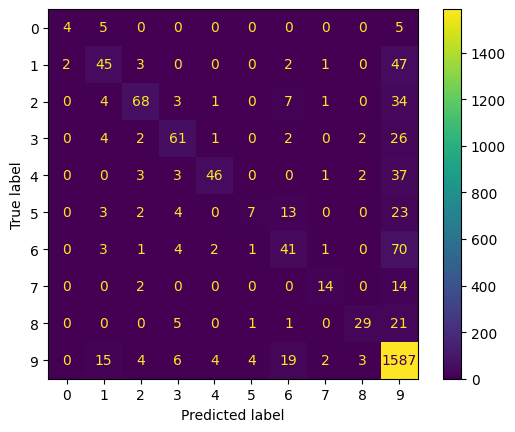

              precision    recall  f1-score   support

           0       0.67      0.29      0.40        14
           1       0.57      0.45      0.50       100
           2       0.80      0.58      0.67       118
           3       0.71      0.62      0.66        98
           4       0.85      0.50      0.63        92
           5       0.54      0.13      0.22        52
           6       0.48      0.33      0.39       123
           7       0.70      0.47      0.56        30
           8       0.81      0.51      0.62        57
           9       0.85      0.97      0.90      1644

    accuracy                           0.82      2328
   macro avg       0.70      0.48      0.56      2328
weighted avg       0.80      0.82      0.80      2328



In [5]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs32"
best_ckpt_idx = "23"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs16

I0000 00:00:1741776099.845877  841430 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10990 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2025-03-12 16:11:47.007136: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1741776107.437408  841814 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-12 16:12:58.737955: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


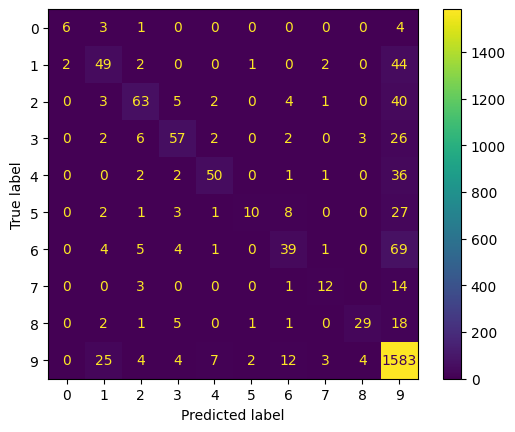

              precision    recall  f1-score   support

           0       0.75      0.43      0.55        14
           1       0.54      0.49      0.52       100
           2       0.72      0.53      0.61       118
           3       0.71      0.58      0.64        98
           4       0.79      0.54      0.65        92
           5       0.71      0.19      0.30        52
           6       0.57      0.32      0.41       123
           7       0.60      0.40      0.48        30
           8       0.81      0.51      0.62        57
           9       0.85      0.96      0.90      1644

    accuracy                           0.82      2328
   macro avg       0.71      0.50      0.57      2328
weighted avg       0.80      0.82      0.80      2328



In [4]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

In [ ]:
from official.vision.serving import export_saved_model_lib
import tensorflow_models as tfm
import yaml
model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open("/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)
    


In [6]:
# best_checkpoint

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path="/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16/best_f1_score/best_ckpt-26",
    export_dir=model_dir+'/best_checkpoint')

model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

2025-03-12 16:18:19.446600: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0       0.75      0.43      0.55        14
           1       0.56      0.47      0.51       100
           2       0.71      0.53      0.61       118
           3       0.73      0.56      0.64        98
           4       0.78      0.54      0.64        92
           5       0.83      0.19      0.31        52
           6       0.61      0.31      0.41       123
           7       0.62      0.33      0.43        30
           8       0.88      0.51      0.64        57
           9       0.85      0.97      0.90      1644

    accuracy                           0.82      2328
   macro avg       0.73      0.48      0.56      2328
weighted avg       0.80      0.82      0.80      2328



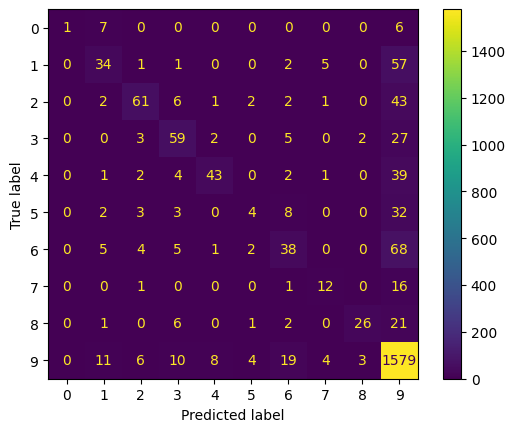

              precision    recall  f1-score   support

           0       1.00      0.07      0.13        14
           1       0.54      0.34      0.42       100
           2       0.75      0.52      0.61       118
           3       0.63      0.60      0.61        98
           4       0.78      0.47      0.59        92
           5       0.31      0.08      0.12        52
           6       0.48      0.31      0.38       123
           7       0.52      0.40      0.45        30
           8       0.84      0.46      0.59        57
           9       0.84      0.96      0.89      1644

    accuracy                           0.80      2328
   macro avg       0.67      0.42      0.48      2328
weighted avg       0.77      0.80      0.77      2328



In [10]:
# intermediate_checkpoint

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path="/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16/ckpt-16000",
    export_dir=model_dir+'/intermediate_checkpoint')

model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16/intermediate_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/ArtDL/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs32_skin

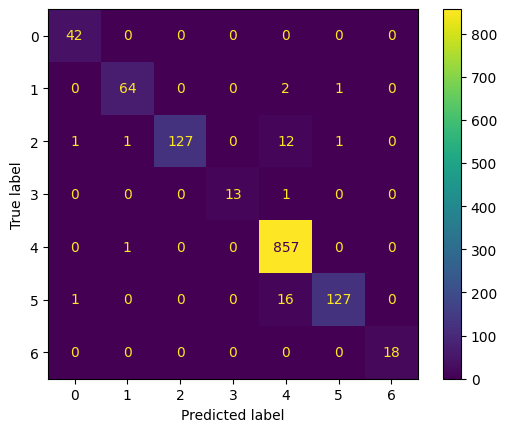

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       0.97      0.96      0.96        67
           2       1.00      0.89      0.94       142
           3       1.00      0.93      0.96        14
           4       0.97      1.00      0.98       858
           5       0.98      0.88      0.93       144
           6       1.00      1.00      1.00        18

    accuracy                           0.97      1285
   macro avg       0.98      0.95      0.97      1285
weighted avg       0.97      0.97      0.97      1285



In [6]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs32_skin/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/skin_cancer/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

2025-03-13 11:29:30.022495: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


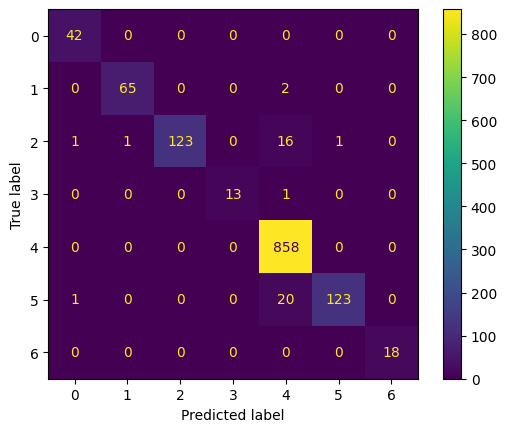

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       0.98      0.97      0.98        67
           2       1.00      0.87      0.93       142
           3       1.00      0.93      0.96        14
           4       0.96      1.00      0.98       858
           5       0.99      0.85      0.92       144
           6       1.00      1.00      1.00        18

    accuracy                           0.97      1285
   macro avg       0.98      0.95      0.96      1285
weighted avg       0.97      0.97      0.97      1285



In [7]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs32_skin"
best_ckpt_idx = "25"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/skin_cancer/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

## vit_baseline_bs16_skin

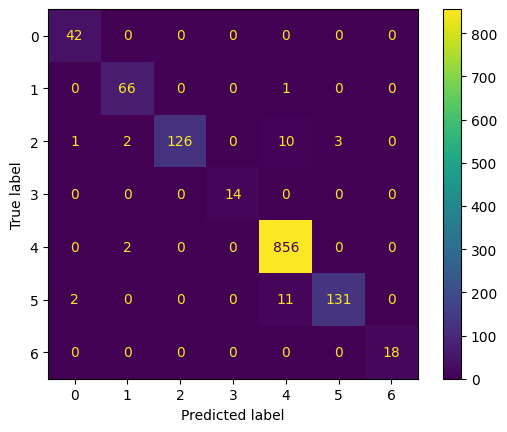

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        42
           1       0.94      0.99      0.96        67
           2       1.00      0.89      0.94       142
           3       1.00      1.00      1.00        14
           4       0.97      1.00      0.99       858
           5       0.98      0.91      0.94       144
           6       1.00      1.00      1.00        18

    accuracy                           0.98      1285
   macro avg       0.98      0.97      0.97      1285
weighted avg       0.98      0.98      0.97      1285



In [8]:
# latest_checkpoint
model_path = '/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_skin/export'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/skin_cancer/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)

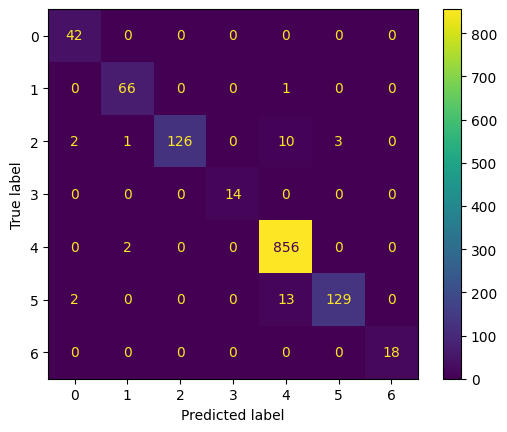

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        42
           1       0.96      0.99      0.97        67
           2       1.00      0.89      0.94       142
           3       1.00      1.00      1.00        14
           4       0.97      1.00      0.99       858
           5       0.98      0.90      0.93       144
           6       1.00      1.00      1.00        18

    accuracy                           0.97      1285
   macro avg       0.97      0.97      0.97      1285
weighted avg       0.97      0.97      0.97      1285



In [9]:
# best_checkpoint

model_dir = "/home/shashank/cv/vit_resnet_finetuning/model_experiments/vit_baseline_bs16_skin"
best_ckpt_idx = "28"

exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_pretrain')

with open(model_dir+"/export/params.yaml", "r") as file:
    override_params = yaml.full_load(file)
exp_config.override(override_params, is_strict=False)

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[224, 224],
    params=exp_config,
    checkpoint_path=model_dir+"/best_f1_score/best_ckpt-"+best_ckpt_idx,
    export_dir=model_dir+'/best_checkpoint')

model_path = model_dir+'/best_checkpoint/'
test_data_path = '/home/shashank/tensorflow_datasets/tfrecords/skin_cancer/test-00000-of-00001.tfrecord'
evalaution(model_path, test_data_path)